In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import pickle

In [2]:
start = '2012-01-01' #last 12 years data
end = '2024-12-21'
stock = 'TSLA' #stock data

data = yf.download(stock, start, end)

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [3]:
data

Price,Close,High,Low,Open,Volume
Ticker,TSLA,TSLA,TSLA,TSLA,TSLA
Date,,,,,
2012-01-03,1.872000,1.966667,1.843333,1.929333,13921500
2012-01-04,1.847333,1.911333,1.833333,1.880667,9451500
2012-01-05,1.808000,1.862000,1.790000,1.850667,15082500
2012-01-06,1.794000,1.852667,1.760667,1.813333,14794500
2012-01-09,1.816667,1.832667,1.741333,1.800000,13455000
...,...,...,...,...,...
2024-12-16,463.019989,463.190002,436.149994,441.089996,114083800
2024-12-17,479.859985,483.989990,457.510010,475.899994,131223000


In [4]:
data.reset_index(inplace=True)  #reset date to index

In [5]:
data

Price,Date,Close,High,Low,Open,Volume
Ticker,,TSLA,TSLA,TSLA,TSLA,TSLA
0,2012-01-03,1.872000,1.966667,1.843333,1.929333,13921500
1,2012-01-04,1.847333,1.911333,1.833333,1.880667,9451500
2,2012-01-05,1.808000,1.862000,1.790000,1.850667,15082500
3,2012-01-06,1.794000,1.852667,1.760667,1.813333,14794500
4,2012-01-09,1.816667,1.832667,1.741333,1.800000,13455000
...,...,...,...,...,...,...
3259,2024-12-16,463.019989,463.190002,436.149994,441.089996,114083800
3260,2024-12-17,479.859985,483.989990,457.510010,475.899994,131223000
3261,2024-12-18,440.130005,488.540009,427.010010,466.500000,149340800


In [6]:
ma_100_days = data.Close.rolling(100).mean() #moving average of 100 days

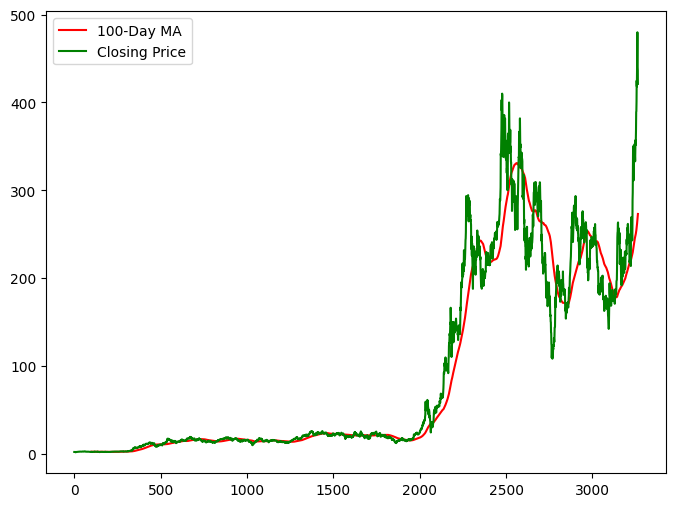

In [7]:
plt.figure(figsize=(8,6))
plt.plot(ma_100_days, 'r', label='100-Day MA') #(smoother trend).
plt.plot(data.Close, 'g', label='Closing Price')
plt.legend()
plt.show()

In [8]:
ma_200_days = data.Close.rolling(200).mean()

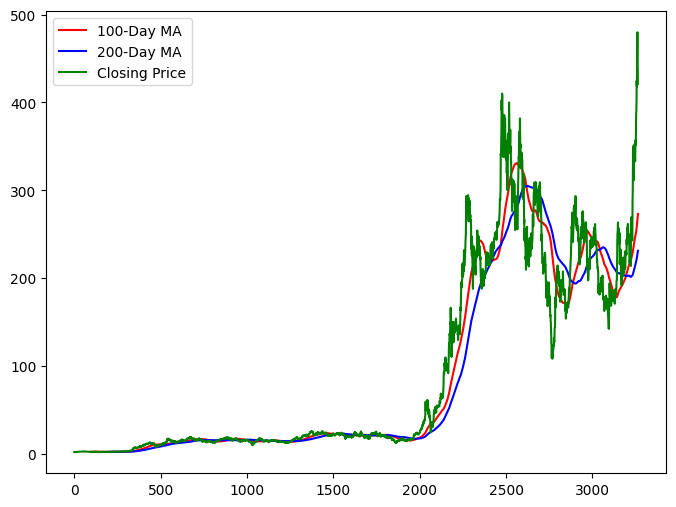

In [9]:
plt.figure(figsize=(8,6))
plt.plot(ma_100_days, 'r', label='100-Day MA')
plt.plot(ma_200_days,'b', label='200-Day MA')
plt.plot(data.Close,'g', label='Closing Price')
plt.legend()
plt.show()

In [10]:
data.dropna(inplace=True) #dropping null values

In [11]:
data_features = data[['Open', 'High', 'Low', 'Close', 'Volume']]


<Axes: >

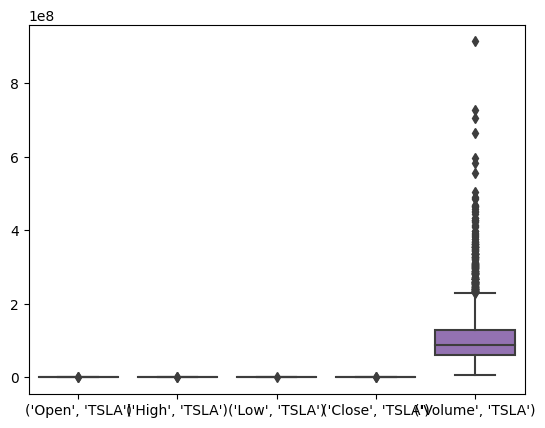

In [12]:
import seaborn as sns
sns.boxplot(data_features)

In [13]:
#train-test split on closing price
data_train = pd.DataFrame(data_features[0: int(len(data)*0.80)])
data_test = pd.DataFrame(data_features[int(len(data)*0.80): len(data)]) #because in timeseries data, the next data is always dependent on the previous data

In [14]:
data_train.shape[0]

2611

In [15]:
data_test.shape[0]

653

In [16]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
data_train_scale = scaler.fit_transform(data_train)

# after fitting scaler
close_min = scaler.data_min_[1]  # 3rd index = Close
close_max = scaler.data_max_[1]


In [17]:
data_train_scale.shape[0]

2611

In [18]:
#array slicing
x = []
y = []

for i in range(100, data_train_scale.shape[0]):
    x.append(data_train_scale[i-100:i])
    y.append(data_train_scale[i,0])

In [19]:
x, y = np.array(x), np.array(y)

In [20]:
x = x.reshape((x.shape[0], 100, 5))  # if 100 days, 5 features


In [21]:
from keras.layers import Dense, Dropout, LSTM
from keras.models import Sequential

In [22]:
'''model = Sequential()
model.add(LSTM(units = 50, activation = 'relu', return_sequences = True,input_shape = ((100, 5))))
                                         #output of one layer will be the input of next
               
model.add(Dropout(0.2)) #20% dropout to prevent overfitting

model.add(LSTM(units = 60, activation='relu', return_sequences = True))
model.add(Dropout(0.3))

model.add(LSTM(units = 80, activation = 'relu', return_sequences = True))
model.add(Dropout(0.4))

model.add(LSTM(units = 120, activation = 'relu'))
model.add(Dropout(0.5))

model.add(Dense(units =1)) #predicting only the closing price
'''

model = Sequential()
model.add(LSTM(units=50, activation='relu', input_shape=(100,5)))
model.add(Dropout(0.2))
model.add(Dense(units=1))  # Predict closing price

model.compile(optimizer='adam', loss='mean_squared_error')


c:\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [23]:
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [24]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)


model.fit(x, y, epochs=20, batch_size=32, validation_split=0.1, callbacks=[early_stopping, checkpoint])


Epoch 1/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - loss: 0.0087 - val_loss: 0.0038
Epoch 2/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0010 - val_loss: 0.0023
Epoch 3/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 6.5441e-04 - val_loss: 0.0027
Epoch 4/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 8.8080e-04 - val_loss: 0.0020
Epoch 5/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 6.1826e-04 - val_loss: 0.0017
Epoch 6/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 6.6000e-04 - val_loss: 0.0043
Epoch 7/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 5.0351e-04 - val_loss: 0.0014
Epoch 8/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 5.3859e-04 - val_loss: 0.0015
Epoch 9/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 4.8327e-04 - val_loss: 0.0015
Epoch 10/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 4.5516e-04 - val_loss: 0.0020
Epoch 11/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 5.7850e-04 - val_loss: 0.0013
Epoch 12/20
71/71 ━━━━━━━━━

In [25]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 50)             │        11,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,755 (131.86 KB)

 Trainable params: 11,251 (43.95 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 22,504 (87.91 KB)

In [26]:
pas_100_days = data_train.tail(100)

In [27]:
data_test = pd.concat([pas_100_days, data_test], ignore_index=True)

In [28]:
data_test_scale  =  scaler.fit_transform(data_test)

In [29]:
x = []
y = []

for i in range(100, data_test_scale.shape[0]):
    x.append(data_test_scale[i-100:i])
    y.append(data_test_scale[i,0])
x, y = np.array(x), np.array(y)

In [30]:
# Make predictions
y_predict = model.predict(x)

# Rescale predictions and true values back to actual Close prices
y_predict_rescaled = y_predict * (close_max - close_min) + close_min
y_true_rescaled = y * (close_max - close_min) + close_min


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


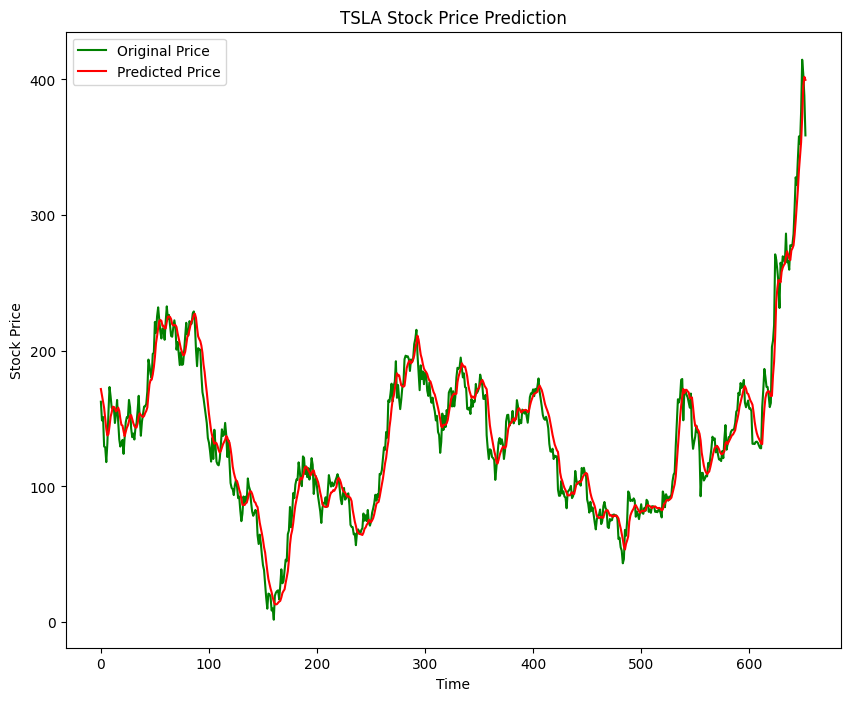

In [31]:
plt.figure(figsize=(10,8))
plt.plot(y_true_rescaled, 'g', label='Original Price')
plt.plot(y_predict_rescaled, 'r', label='Predicted Price')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.title('TSLA Stock Price Prediction')
plt.show()


In [32]:
from sklearn.metrics import mean_absolute_error, r2_score

mae = mean_absolute_error(y, y_predict)
r2 = r2_score(y, y_predict)
print(f"MAE: {mae:.2f}, R²: {r2:.2f}")

MAE: 0.02, R²: 0.95


In [33]:
#pickle.dump(model, open('stock.pkl', 'wb'))
#model.save('model.keras')  # or 'model.keras'
